In [57]:
import os
import subprocess
import numpy as np
import pandas as pd
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
# from sklearn.cross_validation import  cross_val_score
from time import time
from operator import itemgetter

%matplotlib inline

In [58]:
data = pd.read_csv('Titanic.csv',header='infer',parse_dates=True, infer_datetime_format=True);

In [59]:
data.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [60]:
data.dropna(axis=0, how='any')
data_filtered = data[~np.isnan(data['age'])]

In [61]:
data_filtered.describe()

,survived,age,sibsp,parch,fare,body
count,1046.000000,1046.000000,1046.000000,1046.00000,1045.000000,120.00000
mean,0.408222,29.881135,0.502868,0.42065,36.686080,160.87500
std,0.491740,14.413500,0.912167,0.83975,55.732534,98.10392
min,0.000000,0.166700,0.000000,0.00000,0.000000,1.00000
25%,0.000000,21.000000,0.000000,0.00000,8.050000,71.50000
50%,0.000000,28.000000,0.000000,0.00000,15.750000,155.50000
75%,1.000000,39.000000,1.000000,1.00000,35.500000,256.50000
max,1.000000,80.000000,8.000000,6.00000,512.329224,328.00000


In [62]:
data.describe()

,survived,age,sibsp,parch,fare,body
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.486055,14.413500,1.041658,0.865560,51.758669,97.696922
min,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,1.000000,80.000000,8.000000,9.000000,512.329224,328.000000


In [63]:
def sex_to_numeric(x):
    if x=='female':
        return 0
    if x=='male':
        return 1
    

In [64]:
data_filtered['sex'] = data_filtered['sex'].apply(sex_to_numeric)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [65]:
def encode_target(df, target_column):
    """Add column to df with integers for the target.

    Args
    ----
    df -- pandas DataFrame.
    target_column -- column to map to int, producing
                     new Target column.

    Returns
    -------
    df_mod -- modified DataFrame.
    targets -- list of target names.
    """
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod["Target"] = df_mod[target_column].replace(map_to_int)

    return (df_mod, targets)

In [66]:
df2, targets = encode_target(data_filtered, "pclass")

In [67]:
df2 = df2.drop(["pclass"],axis=1)

In [68]:
df2["pclass"] = df2["Target"]

In [69]:
df2.tail(10)

,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,Target,pclass
1295,0,"Windelov, Mr. Einar",1,21.0,0,0,SOTON/OQ 3101317,7.2500,NaN,Southampton,NaN,NaN,NaN,2,2
1296,0,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,Southampton,NaN,131.0,NaN,2,2
1298,0,"Wittevrongel, Mr. Camille",1,36.0,0,0,345771,9.5000,NaN,Southampton,NaN,NaN,NaN,2,2
1299,0,"Yasbeck, Mr. Antoni",1,27.0,1,0,2659,14.4542,NaN,Cherbourg,C,NaN,NaN,2,2
1300,1,"Yasbeck, Mrs. Antoni (Selini Al",0,15.0,1,0,2659,14.4542,NaN,Cherbourg,NaN,NaN,NaN,2,2
1301,0,"Youseff, Mr. Gerious",1,45.5,0,0,2628,7.2250,NaN,Cherbourg,NaN,312.0,NaN,2,2
1304,0,"Zabour, Miss. Hileni",0,14.5,1,0,2665,14.4542,NaN,Cherbourg,NaN,328.0,NaN,2,2
1306,0,"Zakarian, Mr. Mapriededer",1,26.5,0,0,2656,7.2250,NaN,Cherbourg,NaN,304.0,NaN,2,2
1307,0,"Zakarian, Mr. Ortin",1,27.0,0,0,2670,7.2250,NaN,Cherbourg,NaN,NaN,NaN,2,2
1308,0,"Zimmerman, Mr. Leo",1,29.0,0,0,315082,7.8750,NaN,Southampton,NaN,NaN,NaN,2,2


In [70]:
data_filtered.count()

pclass       1046
survived     1046
name         1046
sex          1046
age          1046
sibsp        1046
parch        1046
ticket       1046
fare         1045
cabin         272
embarked     1044
boat          417
body          120
home.dest     685
dtype: int64

In [71]:
data_filtered.head(10)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1st,1,"Allen, Miss. Elisabeth Walton",0,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,1st,1,"Allison, Master. Hudson Trevor",1,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1st,0,"Allison, Miss. Helen Loraine",0,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1st,0,"Allison, Mr. Hudson Joshua Crei",1,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1st,0,"Allison, Mrs. Hudson J C (Bessi",0,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1st,1,"Anderson, Mr. Harry",1,48.0000,0,0,19952,26.549999,E12,Southampton,3,NaN,"New York, NY"
6,1st,1,"Andrews, Miss. Kornelia Theodos",0,63.0000,1,0,13502,77.958298,D7,Southampton,10,NaN,"Hudson, NY"
7,1st,0,"Andrews, Mr. Thomas Jr",1,39.0000,0,0,112050,0.000000,A36,Southampton,NaN,NaN,"Belfast, NI"
8,1st,1,"Appleton, Mrs. Edward Dale (Cha",0,53.0000,2,0,11769,51.479198,C101,Southampton,D,NaN,"Bayside, Queens, NY"
9,1st,0,"Artagaveytia, Mr. Ramon",1,71.0000,0,0,PC 17609,49.504200,NaN,Cherbourg,NaN,22.0,"Montevideo, Uruguay"


In [72]:
X = df2[['pclass','sex','age','sibsp']]

In [73]:
Y = df2['survived']

In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.60)

In [75]:
X_train.head(10)

,pclass,sex,age,sibsp
1111,2,1,0.75,1
1019,2,1,24.00,0
1082,2,1,9.00,0
1196,2,1,29.00,0
1157,2,1,18.00,1
839,2,1,19.00,0
896,2,1,49.00,0
1090,2,0,23.00,0
140,0,1,23.00,0
1079,2,0,22.00,0


In [76]:
print("THE SHAPE OF THE FEATURES (X) TRAIN SET IS")
print(X_train.shape)
print("\n")
print("THE SHAPE OF THE TARGET (y) TRAIN SET IS")
print(y_train.shape)



THE SHAPE OF THE FEATURES (X) TRAIN SET IS
(627, 4)


THE SHAPE OF THE TARGET (y) TRAIN SET IS


NameError: name 'y_train' is not defined

In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform (X_train)
X_test = scaler.transform  (X_test)


nn=MLPClassifier(activation='logistic',solver='sgd',hidden_layer_sizes=(50,50),random_state=1,alpha =6)





In [85]:
nn.fit(X_train,Y_train)


/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


MLPClassifier(activation='logistic', alpha=6, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [86]:
pred=nn.predict(X_train)



In [87]:
in_sample = pd.DataFrame(list(zip(nn.predict(X_train),Y_train)), columns=['predicted', 'actual'])
in_sample

,predicted,actual
0,0,0
1,0,0
2,0,1
3,0,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,1
9,0,1


In [89]:
in_sample = pd.DataFrame(list(zip(decision_tree.predict(X_train), Y_train)), columns=['predicted', 'actual'])
in_sample

,predicted,actual
0,0,0
1,0,0
2,0,1
3,0,1
4,0,0
5,0,0
6,1,0
7,1,0
8,0,1
9,1,1


In [27]:
in_sample_survivor = in_sample[in_sample.actual == 1]
total_survivor = in_sample_survivor.count().actual
print("total_survivor == %.3f" %total_survivor)

in_sample_survivor_success = in_sample_survivor[in_sample_survivor.predicted == 1]
total_survivor_success = in_sample_survivor_success.count().actual
print("total_survivor_success == %.3f" %total_survivor_success)

in_sample_survivor_accuracy = total_survivor_success/ total_survivor
print("in_sample_survivor_accuracy == %.3f" %in_sample_survivor_accuracy )

total_survivor == 253.000
total_survivor_success == 212.000
in_sample_survivor_accuracy == 0.838


In [110]:

in_sample_fatalities = in_sample[in_sample.actual == 0]
total_fatalities = in_sample_fatalities.count().actual
print("total_fatalities == %.3f" %total_fatalities)

in_sample_fatalities_success = in_sample_fatalities[in_sample_fatalities.predicted == 0]
total_fatalities_success = in_sample_fatalities_success.count().actual
print("total_fatalities_success == %.3f" %total_fatalities_success)

in_sample_fatalities_accuracy = total_fatalities_success/ total_fatalities
print("in_sample_fatalities_accuracy == %.3f" %in_sample_fatalities_accuracy )

total_fatalities == 373.000
total_fatalities_success == 368.000
in_sample_fatalities_accuracy == 0.987


In [111]:
# Out sample accuracy

out_sample = pd.DataFrame(list(zip(decision_tree.predict(X_test), Y_test)), columns=['predicted', 'actual'])

In [112]:
out_sample_survivors = out_sample[out_sample.actual == 1]
out_total_survivors = out_sample_survivors.count().actual
print("out-total_survivors == %.3f" %out_total_survivors)

out_sample_survivors_success = out_sample_survivors[out_sample_survivors.predicted == 1]
out_total_survivors_success = out_sample_survivors_success.count().predicted
print("out_total_survivors_success == %.3f" %out_total_survivors_success)

out_sample_survivors_accuracy = out_total_survivors_success/ out_total_survivors
print("out_sample_survivors_accuracy == %.3f" %out_sample_survivors_accuracy )

out-total_survivors == 173.000
out_total_survivors_success == 101.000
out_sample_survivors_accuracy == 0.584


In [113]:
out_sample_fatalities = out_sample[out_sample.actual == 0]
out_total_fatalities = out_sample_fatalities.count().actual
print("out-total_fatalities == %.3f" %out_total_fatalities)

out_sample_fatalities_success = out_sample_fatalities[out_sample_fatalities.predicted == 0]
out_total_fatalities_success = out_sample_fatalities_success.count().actual
print("out_total_fatalities_success == %.3f" %out_total_fatalities_success)

out_sample_fatalities_accuracy = out_total_fatalities_success/ out_total_fatalities
print("out_sample_fatalities_accuracy == %.3f" %out_sample_fatalities_accuracy )

out-total_fatalities == 246.000
out_total_fatalities_success == 213.000
out_sample_fatalities_accuracy == 0.866


In [114]:
def report(grid_scores, n_top=3):
    """Report top n_top parameters settings, default n_top=3.

    Args
    ----
    grid_scores -- output from grid or random search
    n_top -- how many to report, of top models

    Returns
    -------
    top_params -- [dict] top parameter settings found in
                  search
    """
    accuracies = [];
    max_leaf_nodes = [];
    top_scores = sorted(grid_scores,
                        key=itemgetter(1),
                        reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        accuracies.append(score.mean_validation_score);
        max_leaf_nodes.append(score.parameters['max_leaf_nodes'])
        print("Model with rank: {0}".format(i + 1))
        print(("Mean validation score: "
               "{0:.3f} (std: {1:.3f})").format(
               score.mean_validation_score,
               np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
#         accuracies = []
    
    max_leaf_nodes_numerical = [0 if v is None else v for v in max_leaf_nodes]
    miss_classified = []
    for val in accuracies:
        miss_classified.append((1-val)* (data_filtered.count().survived))
    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]
    
    # Color
#     color = ["red" if x == 0 else "blue" for x in data[tv]]
    
    # Plot and label
    plt.scatter(max_leaf_nodes_numerical, miss_classified, s=50)
    plt.xlabel("max_leaf_nodes")
    plt.ylabel("miss_classified")
    plt.xlim([0 , max(max_leaf_nodes_numerical) + 2 ])
    plt.ylim([min(miss_classified) - 20 , max(miss_classified) + 20 ])
    plt.show()
    
    print(miss_classified)
    print(max_leaf_nodes)

    return top_scores[0].parameters

In [115]:
def run_gridsearch(X, y, clf, param_grid, cv=5):
    """Run a grid search for best Decision Tree parameters.

    Args
    ----
    X -- features
    y -- targets (classes)
    cf -- scikit-learn Decision Tree
    param_grid -- [dict] parameter settings to test
    cv -- fold of cross-validation, default 5

    Returns
    -------
    top_params -- [dict] from report()
    """
    grid_search = GridSearchCV(clf,
                               param_grid=param_grid,
                               cv=cv)
    start = time()
    grid_search.fit(X, y)

    print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time() - start,
                len(grid_search.grid_scores_)))

    top_params = report(grid_search.grid_scores_, 9)
    return  top_params


GridSearchCV took 0.30 seconds for 9 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.771 (std: 0.098)
Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 6}

Model with rank: 2
Mean validation score: 0.753 (std: 0.106)
Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 3}

Model with rank: 3
Mean validation score: 0.753 (std: 0.118)
Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 5}

Model with rank: 4
Mean validation score: 0.747 (std: 0.116)
Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 4}

Model with rank: 5
Mean validation score: 0.735 (std: 0.126)
Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 7}

Model with rank: 6
Mean validation score: 0.728 (std: 0.120)
Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 8}

Model with rank: 7
Mean validation score: 0.728 (std: 0.120)
Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 9}

Model with rank: 8
Mean validation score: 0.726 (std: 0.083)
Parameters: {'criterion': 'entr

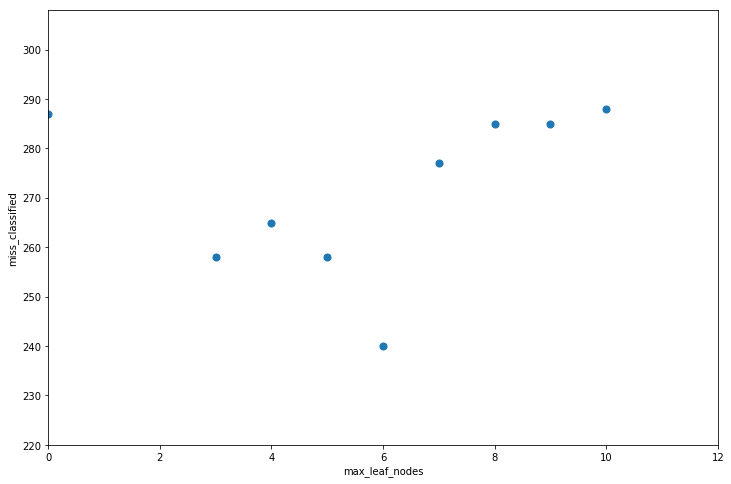

[239.99999999999997, 258.00000000000006, 258.00000000000006, 264.99999999999994, 277.0, 285.0, 285.0, 287.0, 288.0]
[6, 3, 5, 4, 7, 8, 9, None, 10]


In [116]:
# set of parameters to test
param_grid = {"criterion": ["entropy"],
              
              "max_leaf_nodes": [None,3,4,5,6,7,8,9,10],
              }

dt = DecisionTreeClassifier()
ts_gs = run_gridsearch(X, Y, dt, param_grid, cv=10)

In [117]:
# At max_leaf = 6 the acuracie is the highest 0.771 . 
# This is obtained by 10 fold cross validation.

In [118]:
# Fitting model
prune_decision_tree = DecisionTreeClassifier(max_leaf_nodes=6,criterion="entropy")

In [119]:
prune_decision_tree.fit(X_train, Y_train)
visualize_tree(prune_decision_tree, X.columns)

In [120]:
in_sample = pd.DataFrame(list(zip(prune_decision_tree.predict(X_train), Y_train)), columns=['predicted', 'actual'])
out_sample = pd.DataFrame(list(zip(prune_decision_tree.predict(X_test), Y_test)), columns=['predicted', 'actual'])

In [121]:
in_sample_survivor = in_sample[in_sample.actual == 1]
total_survivor = in_sample_survivor.count().actual
print("total_survivor == %.3f" %total_survivor)

in_sample_survivor_success = in_sample_survivor[in_sample_survivor.predicted == 1]
total_survivor_success = in_sample_survivor_success.count().actual
print("total_survivor_success == %.3f" %total_survivor_success)

in_sample_survivor_accuracy = total_survivor_success/ total_survivor
print("in_sample_survivor_accuracy == %.3f" %in_sample_survivor_accuracy )

total_survivor == 254.000
total_survivor_success == 148.000
in_sample_survivor_accuracy == 0.583


In [122]:
in_sample_fatalities = in_sample[in_sample.actual == 0]
total_fatalities = in_sample_fatalities.count().actual
print("total_fatalities == %.3f" %total_fatalities)

in_sample_fatalities_success = in_sample_fatalities[in_sample_fatalities.predicted == 0]
total_fatalities_success = in_sample_fatalities_success.count().actual
print("total_fatalities_success == %.3f" %total_fatalities_success)

in_sample_fatalities_accuracy = total_fatalities_success/ total_fatalities
print("in_sample_fatalities_accuracy == %.3f" %in_sample_fatalities_accuracy )

total_fatalities == 373.000
total_fatalities_success == 360.000
in_sample_fatalities_accuracy == 0.965


In [123]:
out_sample_survivors = out_sample[out_sample.actual == 1]
out_total_survivors = out_sample_survivors.count().actual
print("out-total_survivors == %.3f" %out_total_survivors)

out_sample_survivors_success = out_sample_survivors[out_sample_survivors.predicted == 1]
out_total_survivors_success = out_sample_survivors_success.count().predicted
print("out_total_survivors_success == %.3f" %out_total_survivors_success)

out_sample_survivors_accuracy = out_total_survivors_success/ out_total_survivors
print("out_sample_survivors_accuracy == %.3f" %out_sample_survivors_accuracy )

out-total_survivors == 173.000
out_total_survivors_success == 99.000
out_sample_survivors_accuracy == 0.572


In [124]:
out_sample_fatalities = out_sample[out_sample.actual == 0]
out_total_fatalities = out_sample_fatalities.count().actual
print("out-total_fatalities == %.3f" %out_total_fatalities)

out_sample_fatalities_success = out_sample_fatalities[out_sample_fatalities.predicted == 0]
out_total_fatalities_success = out_sample_fatalities_success.count().actual
print("out_total_fatalities_success == %.3f" %out_total_fatalities_success)

out_sample_fatalities_accuracy = out_total_fatalities_success/ out_total_fatalities
print("out_sample_fatalities_accuracy == %.3f" %out_sample_fatalities_accuracy )

out-total_fatalities == 246.000
out_total_fatalities_success == 237.000
out_sample_fatalities_accuracy == 0.963


In [125]:
# Comparison:

# Without Pruning
# out_sample_fatalities_accuracy == 0.819 , out_sample_survivors_accuracy == 0.648
# in_sample_fatalities_accuracy == 0.967 , in_sample_survivor_accuracy == 0.859


# After pruning 
# out_sample_fatalities_accuracy == 0.965 , out_sample_survivors_accuracy == 0.521
# in_sample_fatalities_accuracy == 0.973 , in_sample_survivor_accuracy == 0.603


#  After pruning in and out sample survivor accuracy has gone down but fatalities acuracy has gone up.

